### Analysis with cluster based permutation test

#### Loading .fif object and creating epochs

In [29]:
import os
import numpy as np
import mne
import sklearn
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Cluster based permutation test

https://mne.tools/stable/auto_tutorials/stats-sensor-space/50_cluster_between_time_freq.html

https://www.fieldtriptoolbox.org/faq/how_can_i_test_an_interaction_effect_using_cluster-based_permutation_tests/

https://www.fieldtriptoolbox.org/tutorial/cluster_permutation_freq/#within-subjects-experiments

https://mailman.science.ru.nl/pipermail/fieldtrip/2016-July/010714.html

https://mne.tools/stable/auto_tutorials/stats-sensor-space/10_background_stats.html#sphx-glr-auto-tutorials-stats-sensor-space-10-background-stats-py

#### Comparison of No music 1st half vs. No music 2nd half in pre-treatment

In [2]:
def mother_of_all_func(filename, freqs_a, freqs_b):
    '''
    returns the power avereaged over channels and relevant frequencies for each time point. 

    args:
        power: 
        channel_indices: the channels wanted
        freq_indices_b: the lowest frequency index wanted
        freq_indices_e: the highest frequency index wanted
        time_indices_b: the lowest time index wanted
        time_indices_e: the highest time index wanted
    '''
    raw = mne.io.read_raw_fif(f"/Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/{filename}.fif")
    
    new_events = np.array([[0,0,1],[900000, 0, 1]])
    
    time_last_event = raw.times[-1] - 900
    
    event_id = {'600_sec': 1}
    tmin, tmax = 0, time_last_event
    raw_epochs = mne.Epochs(raw, new_events, event_id, tmin, tmax, baseline = None, reject=None, verbose=False, preload=True)
    raw_epochs = raw_epochs.resample(250)
    
    # power-spectral analysis for each epoch
    freqs = np.arange(freqs_a, freqs_b,1)
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power_0, itc_0 = tfr_morlet(raw_epochs[0], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)
    power_1, itc_1 = tfr_morlet(raw_epochs[1], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)
 
    return power_0, power_1, raw_epochs

In [3]:
power_0_01, power_1_01, raw_epochs_01 = mother_of_all_func("ID001pre_raw", 14, 30)
power_0_10, power_1_10, raw_epochs_10 = mother_of_all_func("ID010pre_raw", 14, 30)
power_0_11, power_1_11, raw_epochs_11 = mother_of_all_func("ID011pre_raw", 14, 30)
power_0_04, power_1_04, raw_epochs_04 = mother_of_all_func("ID004pre_raw", 14, 30)
power_0_16, power_1_16, raw_epochs_16 = mother_of_all_func("ID016pre_raw", 14, 30)



Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID001pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID010pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID011pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID004pre_raw.fif...
    Range : 0 ... 1530000 =      0.000 ...  1530.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID016pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.


In [4]:
def right_format_func(power_thing):
    power_thing_rf = np.transpose(power_thing.data)
    power_thing_rf = np.mean(power_thing_rf, axis = 0)
    
    return power_thing_rf

In [5]:
power_0 = np.asarray([right_format_func(power_0_01), right_format_func(power_0_10), right_format_func(power_0_11), right_format_func(power_0_16), right_format_func(power_0_04)])
power_1 = np.asarray([right_format_func(power_1_01), right_format_func(power_1_10), right_format_func(power_1_11), right_format_func(power_1_16), right_format_func(power_1_04)])

# apparently, to do a paired samples t-test cluster-based permutation in MNE,
# you have to take the difference between the two and do a 1 sample t-test
# (where the 1 sample is 0)
power_all = power_0 - power_1

In [6]:
power_all.shape

(5, 16, 32)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 32


Text(0.5, 1.0, 'Between-sensor adjacency')

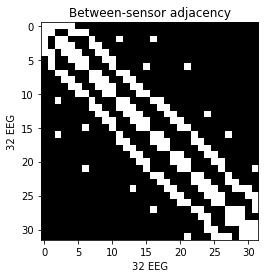

In [7]:
# finding channel adjacency: informs us which channels are next to each other (for co-localisation)
adjacency, ch_names = mne.channels.find_ch_adjacency(raw_epochs_01.info, ch_type='eeg')

# plotting between-sensor adjacency
plt.imshow(adjacency.toarray(), cmap='gray',
           interpolation='nearest')
plt.xlabel('{} EEG'.format(len(ch_names)))
plt.ylabel('{} EEG'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

In [8]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.permutation_cluster_1samp_test(power_all, n_permutations=1000, tail=0,
                                             n_jobs=-1, buffer_size=None, adjacency=adjacency, seed=4, out_type = 'indices')

# selecting clusters with significant p-values
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 2.776445
stat_fun(H1): min=-3.590297 max=3.003475
Running initial clustering
Found 4 clusters
Permuting 15 times (exact test)...


  0%|          |  : 0/15 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [9]:
clusters

[(array([1]), array([19])),
 (array([2, 2]), array([0, 2])),
 (array([2]), array([6])),
 (array([2, 2]), array([23, 28]))]

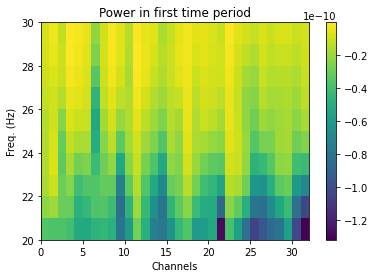

In [9]:
i = 0

plt.imshow(power_all[i], extent=(0,32,20,30), aspect="auto", origin="lower",
          vmin=power_all[i].min(), vmax=power_all[i].max(), picker=True)

plt.xlabel('Channels')
plt.ylabel('Freq. (Hz)')
plt.title('Power in first time period')
plt.colorbar()

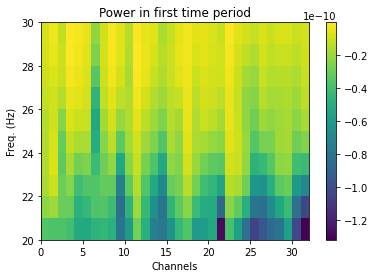

In [10]:
plt.imshow(power_all[0], extent=(0,32,20,30), aspect="auto", origin="lower",
          vmin=power_all[0].min(), vmax=power_all[0].max(), picker=True)

plt.xlabel('Channels')
plt.ylabel('Freq. (Hz)')
plt.title('Power in first time period')
plt.colorbar()

In [10]:
#freq_inds, space_inds = np.squeeze(clusters[0]) # test
freq_inds, space_inds = np.squeeze(clusters[1])


# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
time_0 = np.mean(np.asarray(power_0[:, freq_inds, space_inds]), axis = 1)
time_1 = np.mean(power_1[:, freq_inds, space_inds], axis = 1)

df_1 = pd.DataFrame(np.asarray([time_0, time_1]).T, columns = ['Time_0','Time_1'])
df_1 = df_1.melt(var_name='Time')

Text(0, 0.5, 'Avg power')

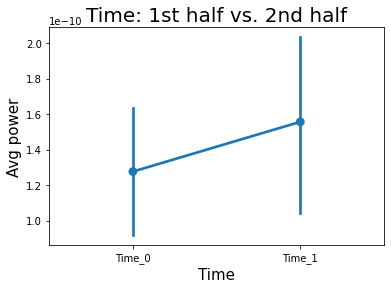

In [12]:
plot = sns.pointplot(x = 'Time', y = 'value', data = df_1)
plot.set_title("Time: 1st half vs. 2nd half", fontsize = 20)
plot.set_xlabel("Time", fontsize = 15)
plot.set_ylabel("Avg power", fontsize = 15)

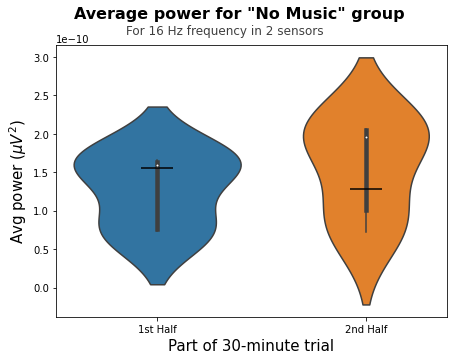

In [42]:
freq_inds, space_inds = np.squeeze(clusters[1])

# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
start = np.mean(np.asarray(power_0[:, freq_inds, space_inds]), axis = 1)
end = np.mean(power_1[:, freq_inds, space_inds], axis = 1)

df_1 = pd.DataFrame(np.asarray([start, end]).T, columns = ['1st Half','2nd Half'])
df_1 = df_1.melt(var_name='Group')

freqs = np.arange(14, 30,1)
#freqs = [str(i) for i in freqs]
ch_inds = np.unique(space_inds)

Means = df_1.groupby('Group')['value'].mean()
temp = Means[1]
Means[1] = Means[0]
Means[0] = temp

fig, ax = plt.subplots(figsize=(7,5))
sns.violinplot(x = 'Group', y = 'value', data = df_1, zorder = 1, ax = ax)
#plot.set_title("Differnece in within-trial change for each experimental group", fontsize = 15, pad = 20)
ax.text(x=-0.4, y=0.00000000035, s='Average power for "No Music" group', fontsize=16, weight='bold')
ax.text(x=-0.15, y=0.00000000033, s='For {} Hz frequency in {} sensors'.format(freqs[freq_inds[0]], len(ch_inds)), fontsize=12, alpha=0.75)
ax.set_xlabel("Part of 30-minute trial", fontsize = 15)
ax.set_ylabel("Avg power ($µV^{2}$)", fontsize = 15)
plt.scatter(x=range(len(Means)),y=Means,c="black", zorder = 2, marker = '_', s = 1000)

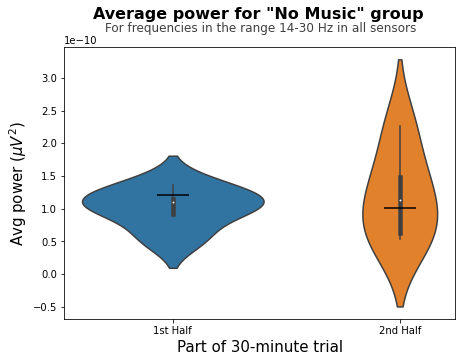

In [44]:

# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
start = np.mean(np.asarray(power_0), axis = 1)
start = np.mean(start, axis = 1)
end = np.mean(np.asarray(power_1), axis = 1)
end = np.mean(end, axis = 1)

df_1 = pd.DataFrame(np.asarray([start, end]).T, columns = ['1st Half','2nd Half'])
df_1 = df_1.melt(var_name='Group')

freqs = np.arange(14, 30,1)
#freqs = [str(i) for i in freqs]
ch_inds = np.unique(space_inds)

Means = df_1.groupby('Group')['value'].mean()
temp = Means[1]
Means[1] = Means[0]
Means[0] = temp

fig, ax = plt.subplots(figsize=(7,5))
sns.violinplot(x = 'Group', y = 'value', data = df_1, zorder = 1, ax = ax)
#plot.set_title("Differnece in within-trial change for each experimental group", fontsize = 15, pad = 20)
ax.text(x=-0.35, y=0.00000000039, s='Average power for "No Music" group', fontsize=16, weight='bold')
ax.text(x=-0.30, y=0.00000000037, s='For frequencies in the range 14-30 Hz in all sensors', fontsize=12, alpha=0.75)
ax.set_xlabel("Part of 30-minute trial", fontsize = 15)
ax.set_ylabel("Avg power ($µV^{2}$)", fontsize = 15)
plt.scatter(x=range(len(Means)),y=Means,c="black", zorder = 2, marker = '_', s = 1000)

#### Comparison of Difference in No-Music vs. Difference in Music also on pre-treatment

In [45]:
# reading in data from no music group and collapsing the within participant dimension
files_no_music = ["ID001pre_raw","ID004pre_raw", "ID010pre_raw", "ID011pre_raw", "ID016pre_raw"]
#files_no_music = ["ID001post_raw","ID004post_raw", "ID010post_raw", "ID011post_raw", "ID016post_raw"]
power_0_nm = []
power_1_nm = []
for i, val in enumerate(files_no_music):
    m = mother_of_all_func(val, 14, 30)
    power_0_nm.append(right_format_func(m[0]))
    power_1_nm.append(right_format_func(m[1]))

raw_epochs_01 = m[2]

power_all_nm = np.asarray(power_0_nm) - np.asarray(power_1_nm)

del power_0_nm
del power_1_nm

# reading in data from music group and collapsing the within participant dimension
files_music = ["ID003pre_raw","ID026pre_raw", "ID027pre_raw", "ID029pre_raw", "ID038pre_raw"]
#files_music = ["ID003post_raw","ID026post_raw", "ID027post_raw", "ID029post_raw", "ID038post_raw"]
power_0_m = []
power_1_m = []
for i, val in enumerate(files_music):
    m = mother_of_all_func(val, 14, 30)
    power_0_m.append(right_format_func(m[0]))
    power_1_m.append(right_format_func(m[1]))
    
power_all_m = np.asarray(power_0_m) - np.asarray(power_1_m)

del power_0_m
del power_1_m

power_all = [power_all_nm, power_all_m]

Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID001pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID004pre_raw.fif...
    Range : 0 ... 1530000 =      0.000 ...  1530.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID010pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID011pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID016pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID003pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 32


Text(0.5, 1.0, 'Between-sensor adjacency')

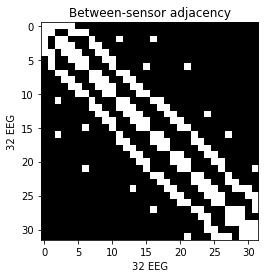

In [46]:
# finding channel adjacency: informs us which channels are next to each other (for co-localisation)
adjacency, ch_names = mne.channels.find_ch_adjacency(raw_epochs_01.info, ch_type='eeg')

# plotting between-sensor adjacency
plt.imshow(adjacency.toarray(), cmap='gray',
           interpolation='nearest')
plt.xlabel('{} EEG'.format(len(ch_names)))
plt.ylabel('{} EEG'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

In [47]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.permutation_cluster_test(power_all, n_permutations=1000, tail=0,
                                             n_jobs=-1, buffer_size=None, adjacency=adjacency, seed=4)

# selecting clusters with significant p-values
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 5.317655
stat_fun(H1): min=0.000003 max=8.746494
Running initial clustering
Found 4 clusters


/var/folders/6f/9pc_m95n353d8tm2r00krnb80000gn/T/ipykernel_3142/2858928932.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  cluster_stats = mne.stats.permutation_cluster_test(power_all, n_permutations=1000, tail=0,


Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [48]:
p_values

array([0.66 , 0.704, 0.475, 0.648])

In [49]:
clusters

[(array([2, 3]), array([2, 2])),
 (array([2]), array([20])),
 (array([5, 6, 7, 7]), array([1, 1, 0, 1])),
 (array([8, 9]), array([28, 28]))]

In [40]:
freq_inds, space_inds = np.squeeze(clusters[2])


# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
no_music = np.mean(np.asarray(power_all_nm[:, freq_inds, space_inds]), axis = 1)
music = np.mean(np.asarray(power_all_m[:, freq_inds, space_inds]), axis = 1)

df_2 = pd.DataFrame(np.asarray([no_music, music]).T, columns = ['No Music','Music'])
df_2 = df_2.melt(var_name='Group')

Text(0, 0.5, 'Avg power')

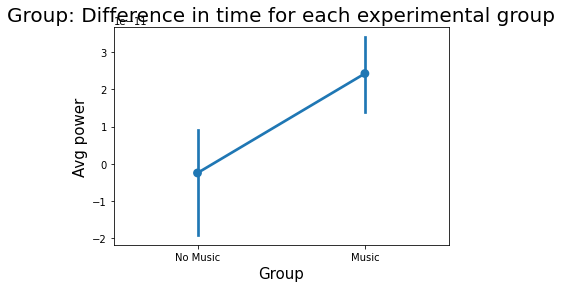

In [41]:
plot = sns.pointplot(x = 'Group', y = 'value', data = df_2)
plot.set_title("Group: Difference in time for each experimental group", fontsize = 20)
plot.set_xlabel("Group", fontsize = 15)
plot.set_ylabel("Avg power", fontsize = 15)

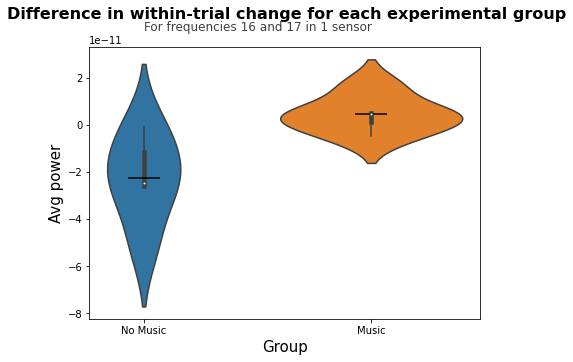

In [113]:
freq_inds, space_inds = np.squeeze(clusters[0])

# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
no_music = np.mean(np.asarray(power_all_nm[:, freq_inds, space_inds]), axis = 1)
music = np.mean(power_all_m[:, freq_inds, space_inds], axis = 1)

df_3 = pd.DataFrame(np.asarray([no_music, music]).T, columns = ['No Music','Music'])
df_3 = df_3.melt(var_name='Group')

freqs = np.arange(14, 30,1)
#freqs = [str(i) for i in freqs]
ch_inds = np.unique(space_inds)

Means = df_3.groupby('Group')['value'].mean()
temp = Means[1]
Means[1] = Means[0]
Means[0] = temp

fig, ax = plt.subplots(figsize=(7,5))
sns.violinplot(x = 'Group', y = 'value', data = df_3, zorder = 1, ax = ax)
#plot.set_title("Differnece in within-trial change for each experimental group", fontsize = 15, pad = 20)
ax.text(x=-0.6, y=0.000000000045, s='Comparison of WTC for each experimental group', fontsize=16, weight='bold')
ax.text(x=-0.0, y=0.000000000040, s='For frequencies {} Hz and {} Hz in {} sensor'.format(freqs[freq_inds[0]], freqs[freq_inds[1]], len(ch_inds)), fontsize=12, alpha=0.75)
ax.set_xlabel("Group", fontsize = 15)
ax.set_ylabel("Avg power ($µV^{2}$)", fontsize = 15)
plt.scatter(x=range(len(Means)),y=Means,c="black", zorder = 2, marker = '_', s = 1000)

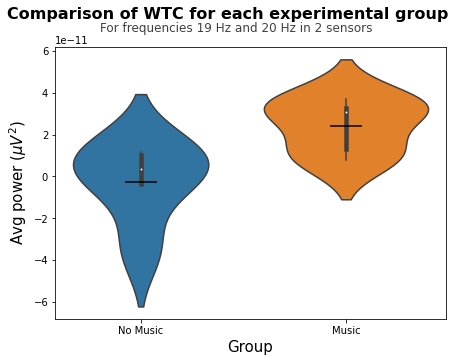

In [59]:
freq_inds, space_inds = np.squeeze(clusters[2])

# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
no_music = np.mean(np.asarray(power_all_nm[:, freq_inds, space_inds]), axis = 1)
music = np.mean(power_all_m[:, freq_inds, space_inds], axis = 1)

df_3_1 = pd.DataFrame(np.asarray([no_music, music]).T, columns = ['No Music','Music'])
df_3_1 = df_3_1.melt(var_name='Group')

freqs = np.arange(14, 30,1)
#freqs = [str(i) for i in freqs]
ch_inds = np.unique(space_inds)

Means = df_3_1.groupby('Group')['value'].mean()
temp = Means[1]
Means[1] = Means[0]
Means[0] = temp

fig, ax = plt.subplots(figsize=(7,5))
sns.violinplot(x = 'Group', y = 'value', data = df_3_1, zorder = 1, ax = ax)
#plot.set_title("Differnece in within-trial change for each experimental group", fontsize = 15, pad = 20)
ax.text(x=-0.65, y=0.000000000075, s='Comparison of WTC for each experimental group', fontsize=16, weight='bold')
ax.text(x=-0.2, y=0.000000000069, s='For frequencies {} Hz and {} Hz in {} sensors'.format(freqs[freq_inds[0]], freqs[freq_inds[1]], len(ch_inds)), fontsize=12, alpha=0.75)
ax.set_xlabel("Group", fontsize = 15)
ax.set_ylabel("Avg power ($µV^{2}$)", fontsize = 15)
plt.scatter(x=range(len(Means)),y=Means,c="black", zorder = 2, marker = '_', s = 1000)

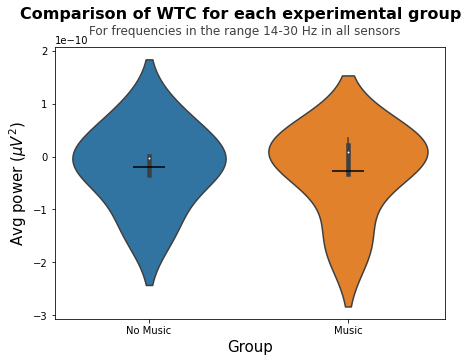

In [57]:

# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
no_music = np.mean(np.asarray(power_all_nm), axis = 1)
no_music = np.mean(no_music, axis = 1)
music = np.mean(np.asarray(power_all_m), axis = 1)
music = np.mean(music, axis = 1)

df_3_2 = pd.DataFrame(np.asarray([no_music, music]).T, columns = ['No Music','Music'])
df_3_2 = df_3_2.melt(var_name='Group')

freqs = np.arange(14, 30,1)
#freqs = [str(i) for i in freqs]
ch_inds = np.unique(space_inds)

Means = df_3_2.groupby('Group')['value'].mean()
temp = Means[1]
Means[1] = Means[0]
Means[0] = temp

fig, ax = plt.subplots(figsize=(7,5))
sns.violinplot(x = 'Group', y = 'value', data = df_3_2, zorder = 1, ax = ax)
#plot.set_title("Differnece in within-trial change for each experimental group", fontsize = 15, pad = 20)
ax.text(x=-0.65, y=0.00000000026, s='Comparison of WTC for each experimental group', fontsize=16, weight='bold')
ax.text(x=-0.3, y=0.00000000023, s='For frequencies in the range 14-30 Hz in all sensors', fontsize=12, alpha=0.75)
ax.set_xlabel("Group", fontsize = 15)
ax.set_ylabel("Avg power ($µV^{2}$)", fontsize = 15)
plt.scatter(x=range(len(Means)),y=Means,c="black", zorder = 2, marker = '_', s = 1000)

#### Comparison of Difference of difference in No-Music vs. Difference of difference in Music 
"Difference of difference" = (time_0_pre - time_1_pre) - (time_0_post - time_1_post)

In [60]:
# pre treatment and no music: collapsing two within participant dimensions
files_no_music_pre = ["ID001pre_raw","ID004pre_raw", "ID010pre_raw", "ID011pre_raw", "ID016pre_raw"]
power_0_nm_pr = []
power_1_nm_pr = []
for i, val in enumerate(files_no_music_pre):
    m = mother_of_all_func(val, 14, 30)
    power_0_nm_pr.append(right_format_func(m[0]))
    power_1_nm_pr.append(right_format_func(m[1]))

raw_epochs_01 = m[2]
    
power_all_nm_pr = np.asarray(power_0_nm_pr) - np.asarray(power_1_nm_pr)

del power_0_nm_pr
del power_1_nm_pr

# post treatment and no music: collapsing two within participant dimensions
files_no_music_post = ["ID001post_raw","ID004post_raw", "ID010post_raw", "ID011post_raw", "ID016post_raw"]
power_0_nm_po = []
power_1_nm_po = []
for i, val in enumerate(files_no_music_post):
    m = mother_of_all_func(val, 14, 30)
    power_0_nm_po.append(right_format_func(m[0]))
    power_1_nm_po.append(right_format_func(m[1]))
    
power_all_nm_po = np.asarray(power_0_nm_po) - np.asarray(power_1_nm_po)

power_all_nm = power_all_nm_pr - power_all_nm_po

del power_0_nm_po
del power_1_nm_po

# pre treatment and music: collapsing two within participant dimensions
files_music_pre = ["ID003pre_raw","ID026pre_raw", "ID027pre_raw", "ID029pre_raw", "ID038pre_raw"]
power_0_m_pr = []
power_1_m_pr = []
for i, val in enumerate(files_music_pre):
    m = mother_of_all_func(val, 14, 30)
    power_0_m_pr.append(right_format_func(m[0]))
    power_1_m_pr.append(right_format_func(m[1]))
    
power_all_m_pr = np.asarray(power_0_m_pr) - np.asarray(power_1_m_pr)

del power_0_m_pr
del power_1_m_pr

# post treatment and no music: collapsing two within participant dimensions
files_music_post = ["ID003post_raw","ID026post_raw", "ID027post_raw", "ID029post_raw", "ID038post_raw"]
power_0_m_po = []
power_1_m_po = []
for i, val in enumerate(files_music_post):
    m = mother_of_all_func(val, 14, 30)
    power_0_m_po.append(right_format_func(m[0]))
    power_1_m_po.append(right_format_func(m[1]))
    
power_all_m_po = np.asarray(power_0_m_po) - np.asarray(power_1_m_po)

power_all_m = power_all_m_pr - power_all_m_po

del power_0_m_po
del power_1_m_po

power_all = [power_all_nm, power_all_m]

Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID001pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID004pre_raw.fif...
    Range : 0 ... 1530000 =      0.000 ...  1530.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID010pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID011pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID016pre_raw.fif...
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening raw data file /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID001post_raw.fif...
    Range : 0 ... 1756000 =      0.000 ...  1756.000 secs
Ready.
Opening raw dat

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 32


Text(0.5, 1.0, 'Between-sensor adjacency')

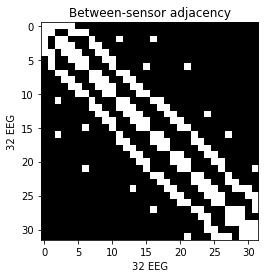

In [61]:
# finding channel adjacency: informs us which channels are next to each other (for co-localisation)
adjacency, ch_names = mne.channels.find_ch_adjacency(raw_epochs_01.info, ch_type='eeg')

# plotting between-sensor adjacency
plt.imshow(adjacency.toarray(), cmap='gray',
           interpolation='nearest')
plt.xlabel('{} EEG'.format(len(ch_names)))
plt.ylabel('{} EEG'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

In [62]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.permutation_cluster_test(power_all, n_permutations=1000, tail=0,
                                             n_jobs=-1, buffer_size=None, adjacency=adjacency, seed=4)

# selecting clusters with significant p-values
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 5.317655
stat_fun(H1): min=0.000007 max=7.055032
Running initial clustering
Found 2 clusters
Permuting 999 times...


/var/folders/6f/9pc_m95n353d8tm2r00krnb80000gn/T/ipykernel_3142/2858928932.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  cluster_stats = mne.stats.permutation_cluster_test(power_all, n_permutations=1000, tail=0,


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [63]:
p_values

array([0.677, 0.79 ])

In [64]:
clusters

[(array([0, 1]), array([20, 20])), (array([14]), array([12]))]

In [65]:
freq_inds, space_inds = np.squeeze(clusters[0])


# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
no_music = np.mean(np.asarray(power_all_nm[:, freq_inds, space_inds]), axis = 1)
music = np.mean(power_all_m[:, freq_inds, space_inds], axis = 1)

df = pd.DataFrame(np.asarray([no_music, music]).T, columns = ['No Music','Music'])
df_3 = df.melt(var_name='Group')

Text(0, 0.5, 'Avg power')

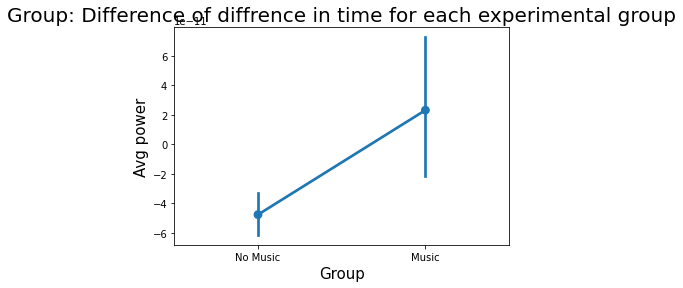

In [66]:
plot = sns.pointplot(x = 'Group', y = 'value', data = df_3)
plot.set_title("Group: Difference of diffrence in time for each experimental group", fontsize = 20)
plot.set_xlabel("Group", fontsize = 15)
plot.set_ylabel("Avg power", fontsize = 15)

I need to make a plot that includes the values at pre and post for both groups so 4 dots will appear to have a better understanding.

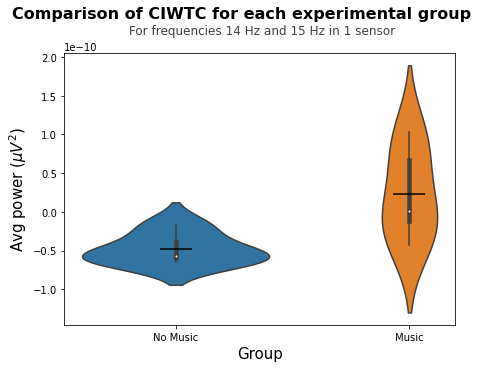

In [71]:
freq_inds, space_inds = np.squeeze(clusters[0])

# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
no_music = np.mean(np.asarray(power_all_nm[:, freq_inds, space_inds]), axis = 1)
music = np.mean(power_all_m[:, freq_inds, space_inds], axis = 1)

df_3 = pd.DataFrame(np.asarray([no_music, music]).T, columns = ['No Music','Music'])
df_3 = df_3.melt(var_name='Group')

freqs = np.arange(14, 30,1)
#freqs = [str(i) for i in freqs]
ch_inds = np.unique(space_inds)

Means = df_3.groupby('Group')['value'].mean()
temp = Means[1]
Means[1] = Means[0]
Means[0] = temp

fig, ax = plt.subplots(figsize=(7,5))
sns.violinplot(x = 'Group', y = 'value', data = df_3, zorder = 1, ax = ax)
#plot.set_title("Differnece in within-trial change for each experimental group", fontsize = 15, pad = 20)
ax.text(x=-0.7, y=0.00000000025, s='Comparison of CIWTC for each experimental group', fontsize=16, weight='bold')
ax.text(x=-0.20, y=0.00000000023, s='For frequencies {} Hz and {} Hz in {} sensor'.format(freqs[freq_inds[0]], freqs[freq_inds[1]], len(ch_inds)), fontsize=12, alpha=0.75)
ax.set_xlabel("Group", fontsize = 15)
ax.set_ylabel("Avg power ($µV^{2}$)", fontsize = 15)
plt.scatter(x=range(len(Means)),y=Means,c="black", zorder = 2, marker = '_', s = 1000)

In [156]:
clusters[1]

(array([14]), array([12]))

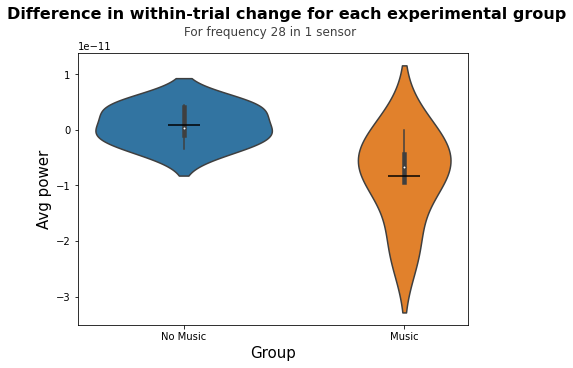

In [173]:
freq_inds, space_inds = np.squeeze(clusters[1])


# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
no_music = np.asarray(power_all_nm[:, freq_inds, space_inds])
music = np.asarray(power_all_m[:, freq_inds, space_inds])

df = pd.DataFrame(np.asarray([no_music, music]).T, columns = ['No Music','Music'])
df_4 = df.melt(var_name='Group')

Means = df_4.groupby('Group')['value'].mean()
temp = Means[1]
Means[1] = Means[0]
Means[0] = temp

freqs = np.arange(14, 30,1)
#freqs = [str(i) for i in freqs]
ch_inds = np.unique(space_inds)

fig, ax = plt.subplots(figsize=(7,5))
sns.violinplot(x = 'Group', y = 'value', data = df_4, zorder = 1, ax = ax)
#plot.set_title("Differnece in within-trial change for each experimental group", fontsize = 15, pad = 20)
ax.text(x=-0.8, y=0.000000000020, s='Difference in within-trial change for each experimental group', fontsize=16, weight='bold')
ax.text(x=-0.0, y=0.000000000017, s='For frequency {} in {} sensor'.format(freqs[freq_inds], len(ch_inds)), fontsize=12, alpha=0.75)
ax.set_xlabel("Group", fontsize = 15)
ax.set_ylabel("Avg power", fontsize = 15)
plt.scatter(x=range(len(Means)),y=Means,c="black", zorder = 2, marker = '_', s = 1000)

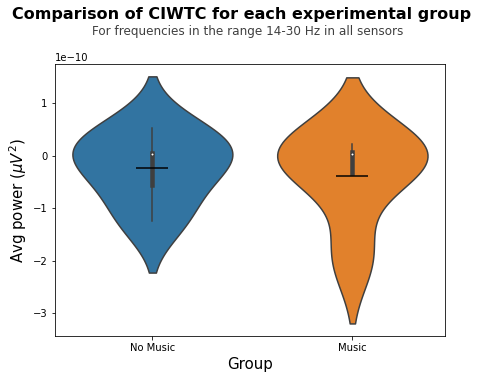

In [82]:

# axis = 0 will be mean across participants, while axis = 1 will be mean across power values
# I will plot the original values even though I actually did the test on the difference values
no_music = np.mean(np.asarray(power_all_nm), axis = 1)
no_music = np.mean(no_music, axis = 1)
music = np.mean(np.asarray(power_all_m), axis = 1)
music = np.mean(music, axis = 1)

df_4_1 = pd.DataFrame(np.asarray([no_music, music]).T, columns = ['No Music','Music'])
df_4_1 = df_4_1.melt(var_name='Group')

freqs = np.arange(14, 30,1)
#freqs = [str(i) for i in freqs]
ch_inds = np.unique(space_inds)

Means = df_4_1.groupby('Group')['value'].mean()
temp = Means[1]
Means[1] = Means[0]
Means[0] = temp

fig, ax = plt.subplots(figsize=(7,5))
sns.violinplot(x = 'Group', y = 'value', data = df_4_1, zorder = 1, ax = ax)
#plot.set_title("Differnece in within-trial change for each experimental group", fontsize = 15, pad = 20)
ax.text(x=-0.7, y=0.00000000026, s='Comparison of CIWTC for each experimental group', fontsize=16, weight='bold')
ax.text(x=-0.3, y=0.00000000023, s='For frequencies in the range 14-30 Hz in all sensors', fontsize=12, alpha=0.75)
ax.set_xlabel("Group", fontsize = 15)
ax.set_ylabel("Avg power ($µV^{2}$)", fontsize = 15)
plt.scatter(x=range(len(Means)),y=Means,c="black", zorder = 2, marker = '_', s = 1000)